# **此程式為DCGAN實作**
#### **原文請至: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html**
######
#### **補充: 以下都是自學用的，因為網路中文介紹GAN的人挺多**
#### **但程式碼某些地方看起來都大同小異(只是換些東西就稱是自己做的課程了)...**
------

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

### **\#參數定義**

In [2]:
dataroot = "./image"    # 要訓練的圖片目錄
workers = 2             # Number of workers for dataloader
batch_size = 128        # Batch size during training
image_size = 64         # 可以理解成圖片解析度 64*64
num_epochs = 3          # 要 train幾個 epochs
lr = 0.0002             # Learning rate，根據 DCGAN 論文應設為 0.0002
beta1 = 0.5             # Beta1 hyperparameter for Adam optimizers
ngpu = 1                # 可用的GPU，如果只用CPU的話，設為0

nc = 3                  # RGB圖片的channel,設為3
nz = 100                # Size of z latent vector (i.e. size of generator input)
ngf = 64
ndf = 64

### **我的配備如下:**
* #### **NVDIA GeForce GTX 1650，驅動版本 537.13**
* #### **CUDA 12.2**
* #### **網路可能查到一堆pytorch不支援CUDA 12.2的資訊，其實已經支援了 (請參考 https://github.com/pytorch/pytorch/issues/91122)** 

In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device," ",torch.__version__)

cuda:0   2.2.0.dev20230927+cu121


-------------------
#### **\#在開始前，可能很多人都想訓練自己的圖片，但我自己試過幾千張，效果都不是很好**
#### **\#以 StyleGAN 為例，各解析度的訓練時間跟GPU數量如下:**
<img src='training time.jpg'/></img>
##### **可參考 https://github.com/NVlabs/stylegan**
######  
#### **所以下面還是用別人的教學跑過一遍就好了...**

### **1.載入資料集**

In [4]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

### **show 一些 training images 出來看看**

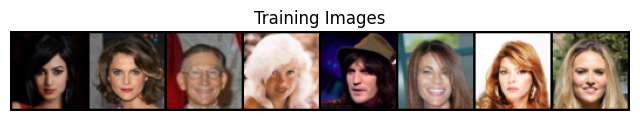

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

### **2.權重初始化。 根據論文，權重應符合常態分布 (mean=0 ,stdev=0.02)**

In [6]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### **3.建立Generator NN**

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### **4.建立Discriminator NN**

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### **5.開始訓練 (建議不要用CPU，會跑大半天)**

In [12]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/3][0/1583]	Loss_D: 1.7947	Loss_G: 4.7667	D(x): 0.5093	D(G(z)): 0.5795 / 0.0129
[0/3][100/1583]	Loss_D: 0.2349	Loss_G: 9.8060	D(x): 0.9660	D(G(z)): 0.1640 / 0.0001
[0/3][200/1583]	Loss_D: 0.4842	Loss_G: 5.1688	D(x): 0.8793	D(G(z)): 0.1510 / 0.0095
[0/3][300/1583]	Loss_D: 0.6076	Loss_G: 2.9589	D(x): 0.8309	D(G(z)): 0.2763 / 0.0800
[0/3][400/1583]	Loss_D: 0.7323	Loss_G: 6.7820	D(x): 0.9165	D(G(z)): 0.3993 / 0.0026
[0/3][500/1583]	Loss_D: 0.7584	Loss_G: 5.9398	D(x): 0.5873	D(G(z)): 0.0086 / 0.0095
[0/3][600/1583]	Loss_D: 0.7166	Loss_G: 7.9192	D(x): 0.8852	D(G(z)): 0.3745 / 0.0010
[0/3][700/1583]	Loss_D: 0.2351	Loss_G: 3.3472	D(x): 0.8727	D(G(z)): 0.0586 / 0.0873
[0/3][800/1583]	Loss_D: 0.2753	Loss_G: 6.0026	D(x): 0.8195	D(G(z)): 0.0217 / 0.0068
[0/3][900/1583]	Loss_D: 0.2099	Loss_G: 5.7504	D(x): 0.8913	D(G(z)): 0.0645 / 0.0086
[0/3][1000/1583]	Loss_D: 0.9652	Loss_G: 6.9014	D(x): 0.9308	D(G(z)): 0.4619 / 0.0044
[0/3][1100/1583]	Loss_D: 0.5702	Loss_G: 5.9091	D(x)

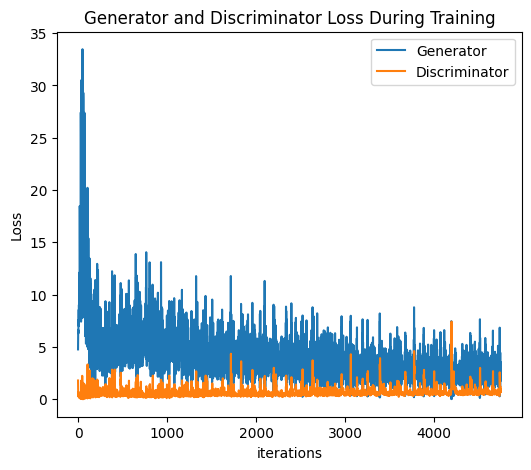

In [13]:
plt.figure(figsize=(6,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### **秀出最後一次生成的結果 img_list[-1]**

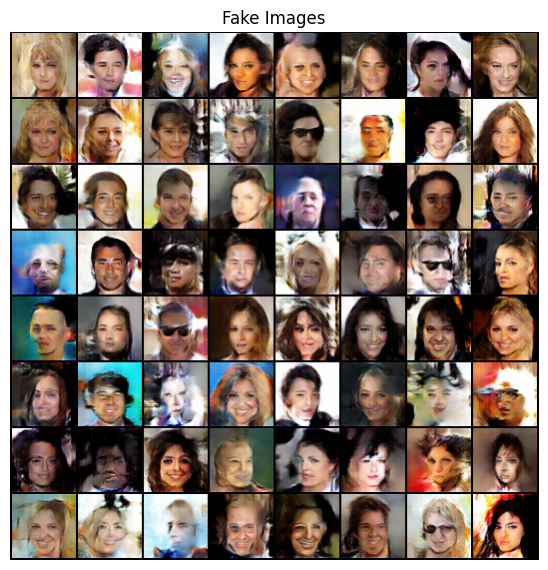

In [14]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()